# Notebook examplifying how to generate cluster lensing quantities

This notebook goes through the steps to generate model data for galaxy cluster weak lensing observables.  In particular, we define a galaxy cluster model that follows and NFW distribution and generate various profiles for the model (mass density, convergence, shear, etc.), which we plot.  Note, a full pipeline to measure a galaxy cluster weak lensing mass requires fitting the observed (or mock) data to a model.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline
import clmm.modeling as m
from astropy.cosmology import FlatLambdaCDM

### Define two plotting functions for later use

In [2]:
def plot_profile_3d(r, profile_vals, profile_label='rho'):
    plt.figure(figsize=(7,4))
    plt.loglog(r, profile_vals)
    plt.xlabel('$r$ $[Mpc/h]$', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
def plot_profile_proj(r, profile_vals, profile_label='rho'):
    plt.figure(figsize=(7,4))
    plt.loglog(r, profile_vals)
    plt.xlabel('$R$ $[Mpc/h]$', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


### Define a cosmology using astropy

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

## Usage exampled of the functions in `modeling.py`

### 1. Define the lens and source properties  
- For the cluster (lens), we define the density profile (NFW here), mass definition ($\Delta_m = 200$), concentration, and cluster redshift.
- We also define a single source plane redshift.

In [4]:
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_mass = 1.e15
cluster_concentration = 4
z_cl = 0.3
z_source = 1.

### 2. Define the 3d and projected radius arrays

The same values are used for both. The distinction between 3D ($r$=`r3d`) and projected radius ($R$=`r_proj`) only serve to highligth the different types of profiles computed below.

In [5]:
r3d = np.logspace(-2, 2, 100) # Mpc/h
r_proj = np.logspace(-2, 2, 100) # Mpc/h

### 3. Calls to the functions of `modeling.py`

#### 3.1 3D density profile of the cluster $\rho(r)$
Here, we use the NFW profile that is defined as $$\rho(r)=\frac{\rho_s}{(r/r_s)(1+r/r_s)^2},$$ where the normalization $\rho_s$ depends on the mass, concentration and redshift of the cluster. CLMM relies on the `cluster-toolkit` implementation.

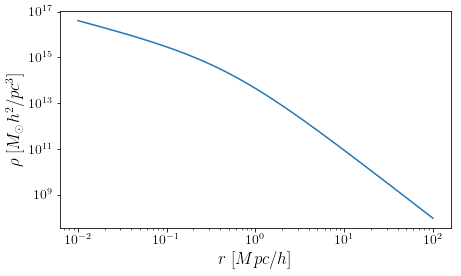

In [6]:
rho = m.get_3d_density(r3d, 
                       mdelta=cluster_mass, 
                       cdelta=cluster_concentration, 
                       z_cl=z_cl, 
                       cosmo=cosmo, 
                       halo_profile_model=density_profile_parametrization)

plot_profile_3d(r3d, rho, '$\\rho \\; [M_\odot h^2/pc^3]$')

#### 3.2 Surface density (projected mass profile) $\Sigma(R)$
It corresponds to the integration of $\rho(r)$ along the line-of-sight passing through the projected distance $R$ from the center of the cluster. CLMM relies on the `cluster-toolkit` implementation.

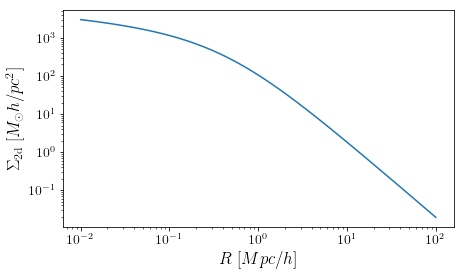

In [14]:
Sigma = m.predict_surface_density(r_proj, 
                                  cluster_mass, 
                                  cluster_concentration, 
                                  z_cl, 
                                  cosmo=cosmo, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model=density_profile_parametrization)

plot_profile_proj(r_proj, Sigma, '$\\Sigma_{\\rm 2d} \\; [M_\odot h/pc^2]$')

#### 3.3 Computation of the predicted shear and convergence
Below, we show calls directly related to the gravitational lensing effect of the cluster on the background source plane 
- Differential surface density $\Delta\Sigma(R) = \bar\Sigma(<R) - \Sigma(R)$
- Critical surface density defined by the geometry of the observer-lens-source system ($D_s$: distance observer-source; $D_l$: distance observer-cluster (lens); $D_{ls}$: distance cluster-source)
$$\Sigma_c = \frac{c^2}{4\pi G}\frac{D_s}{D_l D_{ls}},$$

- Tangential shear $\gamma_t(R) = \Delta\Sigma(R)/\Sigma_c$
- Convergence $\kappa(R) = \Sigma(R)/\Sigma_c$
- Reduced tangential shear 
$$ g_t=\frac{\gamma_t}{1+\kappa}$$

CLMM relies on the `cluster-toolkit` implementation.

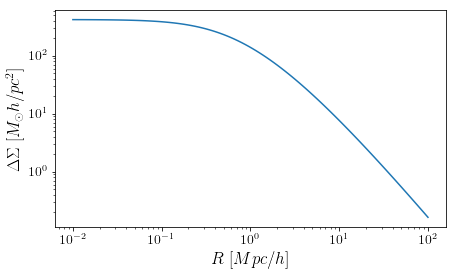

In [8]:
DeltaSigma = m.predict_excess_surface_density(r_proj, 
                                              cluster_mass, 
                                              cluster_concentration, 
                                              z_cl, 
                                              cosmo=cosmo, 
                                              delta_mdef=mass_Delta, 
                                              halo_profile_model=density_profile_parametrization)

plot_profile_proj(r_proj, DeltaSigma, '$\\Delta\\Sigma \\; [M_\odot h/pc^2]$')

In [9]:
Sigmac = m.get_critical_surface_density(cosmo=cosmo, 
                                        z_cluster=z_cl, 
                                        z_source=z_source)

print('Sigma_c =' , Sigmac, 'M_sun h/pc^2')

Sigma_c = 3995.837643649897 M_sun h/pc^2


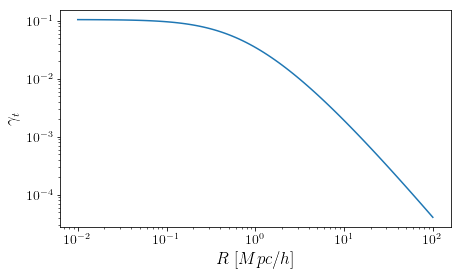

In [10]:
gammat = m.predict_tangential_shear(r_proj, 
                                    mdelta=cluster_mass, 
                                    cdelta=cluster_concentration, 
                                    z_cluster=z_cl, 
                                    z_source=z_source, 
                                    cosmo=cosmo, 
                                    delta_mdef=mass_Delta, 
                                    halo_profile_model=density_profile_parametrization, 
                                    z_src_model='single_plane')

plot_profile_proj(r_proj, gammat, '$\\gamma_t$')

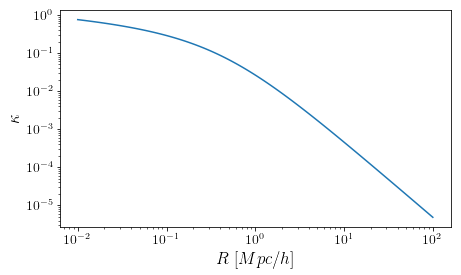

In [11]:
kappa = m.predict_convergence(r_proj, 
                              mdelta=cluster_mass, 
                              cdelta=cluster_concentration, 
                              z_cluster=z_cl, 
                              z_source=z_source,
                              cosmo=cosmo, 
                              delta_mdef=mass_Delta,
                              halo_profile_model=density_profile_parametrization,
                              z_src_model='single_plane')

plot_profile_proj(r_proj, kappa, '$\\kappa$')

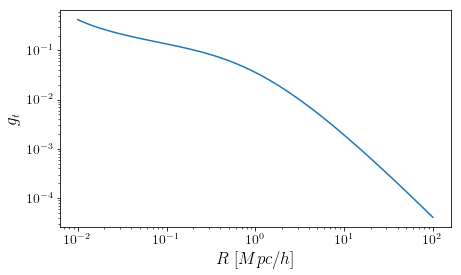

In [12]:
gt = m.predict_reduced_tangential_shear(r_proj, 
                                        mdelta=cluster_mass, 
                                        cdelta=cluster_concentration, 
                                        z_cluster=z_cl, 
                                        z_source=z_source, 
                                        cosmo=cosmo, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')

plot_profile_proj(r_proj, gt, '$g_t$')